# Target-embedding autoencoders

In [1]:
import importlib
import numpy as np
import pandas as pd
import os
from pathlib import Path
from tqdm import tqdm

import torch
from torch import nn, optim, tensor, FloatTensor
from torch.utils.data import Dataset, TensorDataset, DataLoader

from data.skl_synthetic import make_skl_dataset, load_skl_data
import models.linear
# from models.linear import LinearAE, LinearMLP
from plotting import plot_losses, plot_predicted_vs_actual

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(123)

### Load data, set model paramaters 

In [3]:
home = Path.home()
path_for_data = home/"teas-data/sklearn/"
if not os.path.exists(path_for_data):
    make_skl_dataset()
if os.path.exists(path_for_data):
    X_train, X_valid, X_test, Y_train, Y_valid, Y_test = map(FloatTensor, load_skl_data(path_for_data))

In [4]:
batch_size = 128
train_ds = TensorDataset(X_train, Y_train)
valid_ds = TensorDataset(X_valid, Y_valid)
test_ds = TensorDataset(X_test, Y_test)
train_dl = DataLoader(train_ds, batch_size)
valid_dl = DataLoader(valid_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

In [5]:
# these give us some shape values for later
X, Y = next(iter(train_ds))
input_dim = X.shape[0]
hidden_dim = 128
output_dim = Y.shape[0]

### First, train a simple linear autoencoder *for Y*

In [6]:
lae_model = models.linear.LinearAE(output_dim, hidden_dim)

In [7]:
# train the linear AE
epochs = 20
lr = 5e-4
opt = optim.Adam(lae_model.parameters(), lr)
mse = nn.MSELoss()
train_loss, valid_loss = [], []

In [8]:
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([lae_model.update_batch(Y, opt, mse) for _, Y in train_dl])
    this_valid_loss = np.mean([lae_model.update_batch(Y, opt, mse, train=False) for _, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 20/20 [00:03<00:00,  5.06it/s]


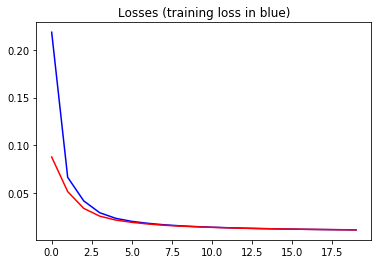

In [9]:
plot_losses(epochs, train_loss, valid_loss)

### Final validation loss (predict Y from Y)

In [10]:
print("Final valid loss: {}".format(valid_loss[-1]))

Final valid loss: 0.011798097402788699


### Visualise predicted vs. actual

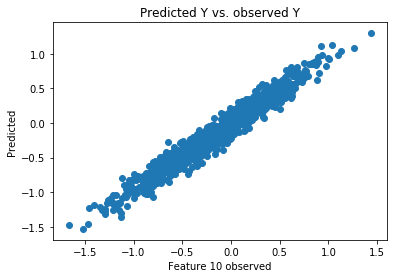

In [11]:
# pick a row, generate predictions
idx = 10
X, Y = valid_ds[idx]
# Y_hat, X_tilde = lfea_model(X)
Y_tilde = lae_model(Y)
plot_predicted_vs_actual(Y, Y_tilde, idx, title = "Predicted Y vs. observed Y")

Now we train an MLP to map X to Z

In [12]:
# importlib.reload(models.linear)

In [22]:
mlp_model = models.linear.LinearMLP(input_dim = 100, hidden_dim = 512, output_dim = 128)

In [23]:
# train the linear AE
epochs = 25
lr = 5e-3
opt = optim.Adam(mlp_model.parameters(), lr)
mse = nn.MSELoss()
train_loss, valid_loss = [], []
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([mlp_model.update_batch(X, lae_model.Z_from_X(Y), opt, mse) for X, Y in train_dl])
    this_valid_loss = np.mean([mlp_model.update_batch(X, lae_model.Z_from_X(Y), opt, mse, train=False) for X, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 25/25 [00:04<00:00,  5.35it/s]


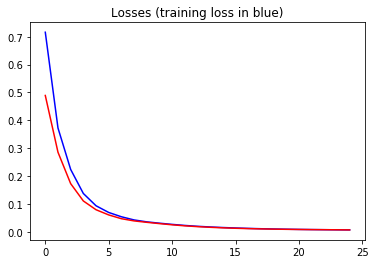

In [24]:
plot_losses(epochs, train_loss, valid_loss)

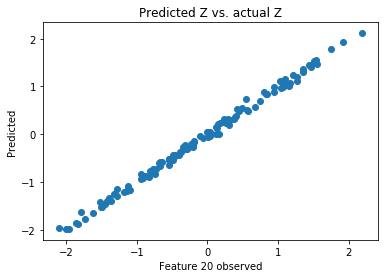

In [25]:
# pick a row, generate predictions
idx = 20
X, Y = valid_ds[idx]
Z = lae_model.Z_from_X(Y)
# Y_hat, X_tilde = lfea_model(X)
Z_hat = mlp_model(X)
plot_predicted_vs_actual(Z, Z_hat, idx, title = "Predicted Z vs. actual Z")

In [26]:
def compute_Y_hat(X): return(lae_model.X_from_Z(mlp_model(X)))

In [27]:
# test losses
test_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in test_ds:
    Y_hat = compute_Y_hat(X)
    test_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())
print("Final test MSE loss on prediction task: {}".format(np.mean(pred_error)))

Final test MSE loss on prediction task: 0.01316989865154028


It worked!!

### Now use these weights in a TEA

In [ ]:
class joint_loss(nn.Module):
    """
    Parameters
    ----------
    lambda_ : float
        Weighting in the joint joss. 
        Higher lambda_ favours lower reconstruction loss.
    """
    def __init__(self, lambda_=0.5):
        super().__init__()
        self.X = X
        self.Y = Y
        self.lambda_ = lambda_
        
    def forward(self, Y, Y_hat, Z, Z_hat):
        mse = nn.MSELoss()
        return ( ((1 - self.lambda_) * mse(Y_hat, Y)) + (self.lambda_ * mse(Z_hat, Z)) )

In [ ]:
ltea_model = models.linear.LinearTEA(input_dim, hidden_dim, output_dim)
ltea_model

### Copy the weights and biases from the trained AE

In [ ]:
ltea_model.input_Y.load_state_dict(lae_model.input.state_dict(), strict=True)

In [ ]:
ltea_model.predict_Y.load_state_dict(lae_model.output.state_dict(), strict=True)

In [ ]:
# train the linear TEA
epochs = 5
lr = 1e-3
opt = optim.Adam(ltea_model.parameters(), lr)
criterion = joint_loss(lambda_= 1.0)
train_loss, valid_loss = [], []

In [ ]:
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([ltea_model.update_batch(X, Y, opt, criterion) for X, Y in train_dl])
    this_valid_loss = np.mean([ltea_model.update_batch(X, Y, opt, criterion, train=False) for X, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

In [ ]:
plot_losses(epochs, train_loss, valid_loss)

### Final validation loss on predicting Y from X

In [ ]:
# validation losses
test_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in valid_ds:
    Y_hat = ltea_model.predict_Y_from_X(X)
    test_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())
print("Final validation MSE loss on prediction task: {}".format(np.mean(pred_error)))

Results for different values of lambda:

| Lambda   | Final validation loss |
| :------- | :------------------   |
| 0.00     | 0.5848469138145447    |
| 0.25     | 0.20141418278217316   |
| 0.50     | 0.1873609572649002    |
| 0.75     |     ||

The best performing model(s) favour Y_hat loss.

### Visualise predicted vs. actual

In [ ]:
# pick a row, generate predictions
idx = 10
X, Y = test_ds[idx]
Y_hat_train, _, _ = ltea_model(X, Y)
Y_hat_infer = ltea_model.predict_Y_from_X(X)

In [ ]:
plot_predicted_vs_actual(Y, Y_hat_infer, idx, title = "Predicted Y vs. observed Y")

### Test loss 

In [ ]:
# test losses
test_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in test_ds:
    Y_hat, _ = lfea_model(X)
    test_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())
print("Final test MSE loss on prediction task: {}".format(np.mean(pred_error)))

In [ ]:
gc.collect()